# Dual Momentum

Description

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import historic_cdi, historic_imab5, historic_sp500, STAR_DATE, END_DATE

### Importando os dados

In [2]:
IBOV = yf.Ticker('^BVSP')

ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [3]:
cdi = historic_cdi(start=STAR_DATE, end=END_DATE)
imab5 = historic_imab5(start=STAR_DATE, end=END_DATE)
sp500_prices = historic_sp500(start=STAR_DATE, end=END_DATE, brl=True)

In [4]:
prices = pd.concat([cdi, imab5, ibov_prices, sp500_prices], keys=['CDI', 'IMA-B 5', 'IBOV', 'SP500 BRL'], join='outer', axis=1)
prices = (prices / prices.iloc[0])
prices = prices.dropna()

prices

,CDI,IMA-B 5,IBOV,SP500 BRL
2004-01-02,1.000000,1.000000,1.000000,1.000000
2004-01-05,1.000601,1.000576,1.048429,1.004152
2004-01-06,1.001202,1.001922,1.050390,1.001270
2004-01-07,1.001803,1.003517,1.038984,1.011210
2004-01-08,1.002405,1.007081,1.056672,1.011452
...,...,...,...,...
2024-09-03,8.218644,11.254458,5.985877,9.716471
2024-09-04,8.221871,11.275119,6.064201,9.724193
2024-09-05,8.225100,11.288138,6.081622,9.641519
2024-09-06,8.228330,11.287673,5.995634,9.416444


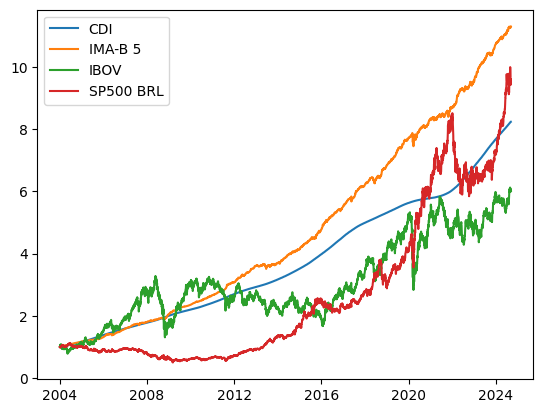

In [5]:
plt.plot(prices)
plt.legend(prices.columns)
plt.show()

In [6]:
ytd_returns = prices.pct_change(periods=252).dropna()

ytd_returns

,CDI,IMA-B 5,IBOV,SP500 BRL
2005-01-18,0.170835,0.183719,0.073246,0.014527
2005-01-19,0.170891,0.183849,0.031404,0.002440
2005-01-20,0.170966,0.182960,0.001442,-0.001142
2005-01-21,0.171042,0.181979,0.021355,-0.025354
2005-01-24,0.171117,0.178574,0.020281,-0.036901
...,...,...,...,...
2024-09-03,0.117784,0.080597,0.164147,0.430686
2024-09-04,0.117675,0.083827,0.189480,0.418531
2024-09-05,0.117566,0.084613,0.175161,0.422258
2024-09-06,0.117457,0.082510,0.139137,0.386617


In [7]:
time_series = pd.to_datetime(ytd_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

ytd_returns.loc[first_trading_day.values]

,CDI,IMA-B 5,IBOV,SP500 BRL
2005-01-18,0.170835,0.183719,0.073246,0.014527
2005-02-01,0.172278,0.168021,0.051694,-0.023893
2005-03-01,0.173851,0.146242,0.250733,-0.058704
2005-04-01,0.175502,0.141318,0.238791,-0.033230
2005-05-02,0.178067,0.144570,0.107252,-0.105415
...,...,...,...,...
2024-05-02,0.128185,0.088211,0.199083,0.263419
2024-06-03,0.126073,0.091150,0.114855,0.343807
2024-07-01,0.123483,0.087676,0.046108,0.433863
2024-08-01,0.119943,0.090874,0.083733,0.408701


In [8]:
conditions = [
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']) & (ytd_returns['IBOV'] > ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']) & (ytd_returns['IBOV'] <= ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] <= ytd_returns['CDI']),
]

cases = ['IBOV', 'SP500 BRL', 'IMA-B 5']

ytd_returns['Investment'] = np.select(conditions, cases, default=None)
ytd_returns['Investment'] = ytd_returns['Investment'].ffill()

ytd_returns

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2005-01-18,0.170835,0.183719,0.073246,0.014527,IMA-B 5
2005-01-19,0.170891,0.183849,0.031404,0.002440,IMA-B 5
2005-01-20,0.170966,0.182960,0.001442,-0.001142,IMA-B 5
2005-01-21,0.171042,0.181979,0.021355,-0.025354,IMA-B 5
2005-01-24,0.171117,0.178574,0.020281,-0.036901,IMA-B 5
...,...,...,...,...,...
2024-09-03,0.117784,0.080597,0.164147,0.430686,SP500 BRL
2024-09-04,0.117675,0.083827,0.189480,0.418531,SP500 BRL
2024-09-05,0.117566,0.084613,0.175161,0.422258,SP500 BRL
2024-09-06,0.117457,0.082510,0.139137,0.386617,SP500 BRL


In [9]:
ytd_returns['Investment'].value_counts(normalize=True).round(2)

Investment
IMA-B 5      0.50
IBOV         0.38
SP500 BRL    0.11
Name: proportion, dtype: float64

In [10]:
dual_momentum = prices.pct_change().join(ytd_returns[['Investment']], how='right')

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2005-01-18,0.001297,0.001422,-0.033502,0.012099,IMA-B 5
2005-01-19,0.000649,0.000685,0.007555,-0.007811,IMA-B 5
2005-01-20,0.000665,0.000594,-0.027234,-0.006433,IMA-B 5
2005-01-21,0.000665,0.000761,0.008810,-0.014554,IMA-B 5
2005-01-24,0.000665,0.000660,0.015954,-0.011611,IMA-B 5
...,...,...,...,...,...
2024-09-03,0.000786,0.000342,-0.012139,-0.027000,SP500 BRL
2024-09-04,0.000393,0.001836,0.013085,0.000795,SP500 BRL
2024-09-05,0.000393,0.001155,0.002873,-0.008502,SP500 BRL
2024-09-06,0.000393,-0.000041,-0.014139,-0.023344,SP500 BRL


In [11]:
dual_momentum['Dual Momentum'] = dual_momentum.apply(lambda row: row[row['Investment']], axis=1)
dual_momentum = dual_momentum.drop(columns=['Investment'])

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-18,0.001297,0.001422,-0.033502,0.012099,0.001422
2005-01-19,0.000649,0.000685,0.007555,-0.007811,0.000685
2005-01-20,0.000665,0.000594,-0.027234,-0.006433,0.000594
2005-01-21,0.000665,0.000761,0.008810,-0.014554,0.000761
2005-01-24,0.000665,0.000660,0.015954,-0.011611,0.000660
...,...,...,...,...,...
2024-09-03,0.000786,0.000342,-0.012139,-0.027000,-0.027000
2024-09-04,0.000393,0.001836,0.013085,0.000795,0.000795
2024-09-05,0.000393,0.001155,0.002873,-0.008502,-0.008502
2024-09-06,0.000393,-0.000041,-0.014139,-0.023344,-0.023344


In [12]:
dual_momentum_eval = (1 + dual_momentum).cumprod()
dual_momentum_eval = (dual_momentum_eval / dual_momentum_eval.iloc[0]) - 1

dual_momentum_eval

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-18,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-19,0.000649,0.000685,0.007555,-0.007811,0.000685
2005-01-20,0.001314,0.001280,-0.019885,-0.014194,0.001280
2005-01-21,0.001980,0.002042,-0.011250,-0.028541,0.002042
2005-01-24,0.002646,0.002704,0.004525,-0.039820,0.002704
...,...,...,...,...,...
2024-09-03,6.019473,8.507709,4.577359,8.577344,16.093387
2024-09-04,6.022230,8.525164,4.650338,8.584955,16.106972
2024-09-05,6.024988,8.536162,4.666570,8.503465,15.961531
2024-09-06,6.027746,8.535769,4.586450,8.281613,15.565574


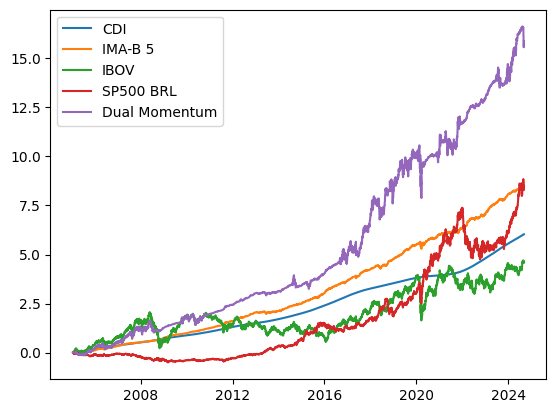

In [13]:
plt.plot(dual_momentum_eval)
plt.legend(dual_momentum_eval.columns)
plt.show()

In [14]:
dual_momentum_eval = dual_momentum_eval + 1
dual_momentum_eval.index = pd.to_datetime(dual_momentum_eval.index)

series_start = dual_momentum_eval.index.min()
series_end = dual_momentum_eval.index.max()

years = (series_end - series_start).days / 365.25

avg_return = (dual_momentum_eval.iloc[-1] / (dual_momentum_eval.iloc[0])) ** (1 / years) - 1
avg_vol = dual_momentum.std() * (252 ** 0.5)

In [15]:
total_results = pd.concat([avg_return, avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)
total_results['Sharpe Ratio'] = (total_results['Avg Return'] - 0.10) / total_results['Avg Vol']

total_results

,Avg Return,Avg Vol,Sharpe Ratio
CDI,0.104390,0.002702,1.624900
IMA-B 5,0.121682,0.029026,0.746969
IBOV,0.091606,0.268577,-0.031252
SP500 BRL,0.121180,0.212064,0.099877
Dual Momentum,0.154740,0.164825,0.332111


### Benchmark

In [16]:
naive_portfolio = dual_momentum_eval[['IBOV', 'SP500 BRL', 'CDI', 'IMA-B 5']].mean(axis=1).rename('Naive Portfolio')
naive_portfolio.index = pd.to_datetime(naive_portfolio.index).date

naive_portfolio

2005-01-18    1.000000
2005-01-19    1.000269
2005-01-20    0.992129
2005-01-21    0.991058
2005-01-24    0.992514
                ...   
2024-09-03    7.920471
2024-09-04    7.945672
2024-09-05    7.932796
2024-09-06    7.857895
2024-09-09    7.904646
Name: Naive Portfolio, Length: 4740, dtype: float64

In [17]:
absolute_model = pd.read_csv('data/export_absolute_model.csv', index_col=0)
absolute_model.index = pd.to_datetime(absolute_model.index).date

In [18]:
relative_model = pd.read_csv('data/export_relative_model.csv', index_col=0)
relative_model.index = pd.to_datetime(relative_model.index).date

In [21]:
benchmark_models = [
    naive_portfolio,
    absolute_model['Return'] + 1,
    relative_model['Return'],
    dual_momentum_eval['Dual Momentum'],
]

benchmark = pd.concat(benchmark_models, keys=['Naive Portfolio', 'Absolute Momentum', 'Relative Momentum', 'Dual Momentum'], join='inner', axis=1)

benchmark

,Naive Portfolio,Absolute Momentum,Relative Momentum,Dual Momentum
2005-01-18,1.000000,1.000000,1.000000,1.000000
2005-01-19,1.000269,1.000685,1.007555,1.000685
2005-01-20,0.992129,1.001280,0.980115,1.001280
2005-01-21,0.991058,1.002042,0.988750,1.002042
2005-01-24,0.992514,1.002704,1.004525,1.002704
...,...,...,...,...
2024-09-03,7.920471,6.420633,13.608381,17.093387
2024-09-04,7.945672,6.504647,13.619196,17.106972
2024-09-05,7.932796,6.523333,13.503407,16.961531
2024-09-06,7.857895,6.431099,13.188178,16.565574


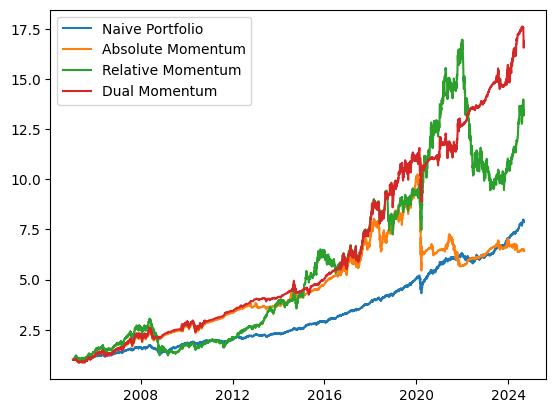

In [22]:
plt.plot(benchmark)
plt.legend(benchmark.columns)
plt.show()